<a href="https://colab.research.google.com/github/foxtrotmike/musings/blob/main/srijay_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Performs batch correction on the data received from Manchester

In [2]:
!pip install combat

  Preparing metadata (setup.py) ... done
  Created wheel for combat: filename=combat-0.3.3-py3-none-any.whl size=36777 sha256=56a5d146c79772360a21d3aeedb695db454fd640b10c205f06661938751a7161
  Stored in directory: /root/.cache/pip/wheels/0d/e4/46/5c7b89d38f5160cf8f2fdda0a52c93439b6e7d9d661e8336f4
Successfully built combat


In [ ]:
!pip install umap-learn

In [5]:
ls sample_data #upload srijaydata.xlsx

anscombe.json*               california_housing_train.csv  mnist_train_small.csv  srijaydata.xlsx
california_housing_test.csv  mnist_test.csv                README.md*


In [8]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 24 01:11:58 2023

@author: fayya
"""

import pandas as pd

df = pd.read_excel(r'./sample_data/srijaydata.xlsx')
non_expression = ['Unnamed: 0', 'VisSpot', 'Location_Center_X', 'Location_Center_Y','Unnamed: 43','Unnamed: 42']
expression_cols = list(set(df.keys()).difference(non_expression))

In [34]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def transform(z):
    zlog = np.log10(z[z>0])
    p25,p75 = zlog.quantile([0.25,0.75])
    def map_to_category(value):
        if value < p25:
            return 1
        elif value <= p75:
            return 2
        else:
            return 3
    tzlog = zlog#.apply(map_to_category)
    tz = z.copy()
    tz[tz>0] = tzlog
    return tz
def ZSSTransform(z):
    zlog = np.log10(z[z>0])
    tzlog = (zlog-np.mean(zlog))/np.std(zlog)
    tzlog_min = np.min(tzlog)-3 #zero is assumed to be at least 1000 times smaller than the lowest non-zero value
    tz = z.copy()
    tz[tz>0] = tzlog
    tz[tz==0] = tzlog_min
    return tz

def plot2D(X,C,title = '',xidx=0,yidx=1):
    import umap
    reducer = umap.UMAP()
    #reducer = PCA()

    reducer = reducer.fit(X)
    #plt.figure();plt.plot(np.cumsum(pca.explained_variance_ratio_)); plt.show()
    Z = reducer.transform(X)
    dfZ = pd.DataFrame(Z[:,[xidx,yidx]], columns=['X', 'Y']) #select PCA axes here
    dfZ['Group'] = C
    import seaborn as sns
    #sns.pairplot(data=dfZ, hue='Group')
    sns.pairplot(data=dfZ, hue='Group')
    #sns.pairplot(data=dfZ, kind = 'kde',hue='Group')
    #sns.kdeplot(data=dfZ, x='X', y='Y', hue='Group', fill=True);
    plt.title(title)


    """
    unique_categories = dfZ['Group'].unique()
    colors = plt.cm.get_cmap('jet', len(unique_categories))
    plt.figure()
    for i, category in enumerate(unique_categories):
        subset = dfZ[dfZ['Group'] == category]
        plt.hexbin(subset['X'], subset['Y'], gridsize=100, cmap=colors, mincnt=10, alpha=0.3, label=category)
    import matplotlib.patches as mpatches
    legend_handles = [mpatches.Patch(color=colors[i], label=category) for i, category in enumerate(unique_categories)]
    plt.legend(handles=legend_handles)
    """

    """

    plt.figure();plt.hexbin(dfZ.X, dfZ.Y, gridsize=100, cmap='Blues');plt.title(title);    plt.xlabel('PCA-'+str(xidx));plt.ylabel('PCA-'+str(yidx))

    # Unique groups for color mapping
    groups = dfZ['Group'].unique()
    plt.figure()
    # Plot
    for group in groups:
        subset = dfZ[dfZ['Group'] == group]
        plt.scatter(subset['X'], subset['Y'], label=group)

    # Add legend and labels
    plt.legend()
    plt.xlabel('PCA-'+str(xidx))
    plt.ylabel('PCA-'+str(yidx))
    plt.title(title)
    plt.show()
    """

def plotHist(X,title=''):

    fig, axes = plt.subplots(nrows=3, ncols=13, figsize=(20, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < len(expression_cols):
            c = expression_cols[i]
            ax.hist(X[c],density = True);#ax.title(c)
            ax.set_title(c)
            #ax.axis('off')
            ax.yaxis.set_visible(False)
        else:
            # Hide unused subplots
            ax.axis('off')
    plt.title(title)
    plt.show()

#%%




In [35]:
#from sklearn.linear_model import LinearRegression
X = df[expression_cols][:-1]#last row is nan
Xt = X.apply(ZSSTransform) #apply the log transform
C = df.VisSpot.apply(lambda x: str(x)[-2:])[:-1]# get the image IDs, last row is nan so ignore
C_encoded = pd.get_dummies(C).values
#X_corrected = Xt
"""
# Correct for batch effects using linear regression
model = LinearRegression()
model.fit(C_encoded, X)
X_corrected = X - model.predict(C_encoded)
"""
#perform correction using pycombat
from combat.pycombat import pycombat
X_corrected = pycombat(Xt.T,C).T

Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [ ]:
#Plot histograms
plotHist(X,'Original');plotHist(Xt,'Transformed');plotHist(X_corrected,'Corrected');


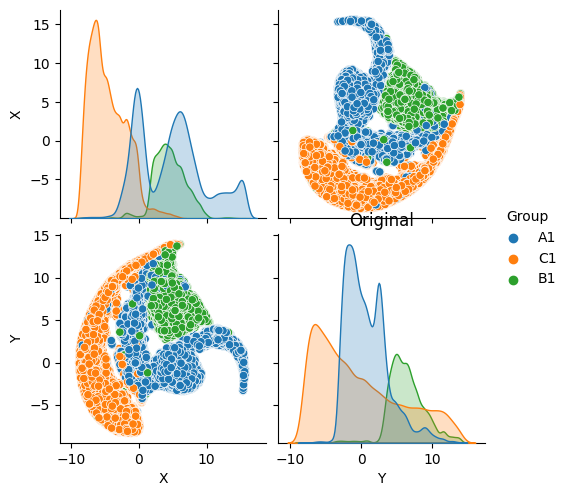

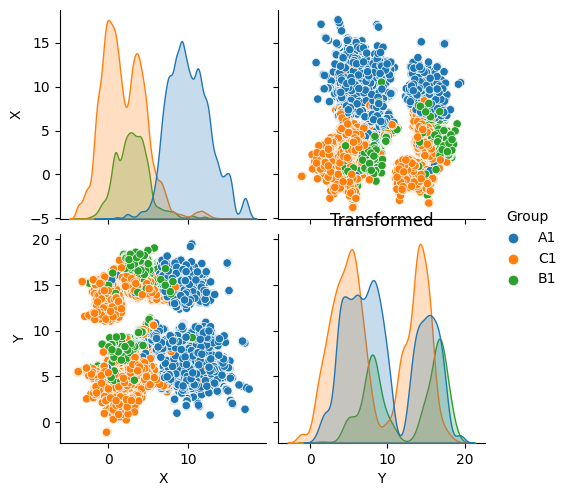

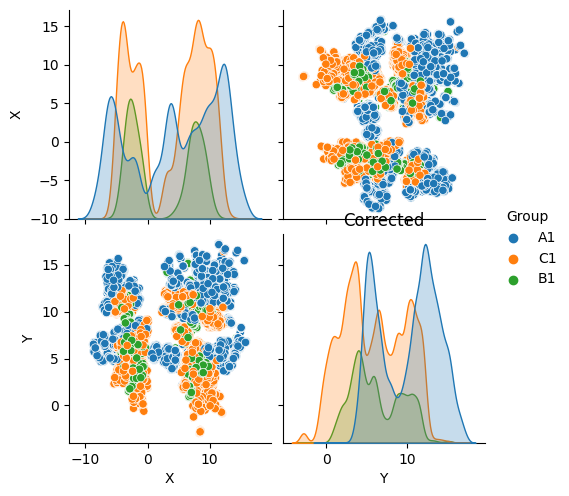

In [36]:
#plot scatter or density plots -- may take time though due to number of points
plot2D(X,C,'Original');
plot2D(Xt,C,'Log Transformed')
plot2D(X_corrected,C,'Log transformed and Corrected')